In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

# Import custom logger
sys.path.append('..')
from result_logger import log_result

2026-02-02 07:17:40.746007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 07:17:42.087409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 07:18:07.340385: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# ============================
# CONFIGURATION
# ============================
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3


PUBLIC_PREP_DIR = "../Dataset/preprocessed_Public"
SELF_RAW_DIR = "../Dataset/SelfCollected_Dataset"

# Create models directory
os.makedirs('models', exist_ok=True)

In [3]:
# ============================
# DATA GENERATORS
# ============================


# Training & validation generator (public dataset)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_gen = train_datagen.flow_from_directory(
    os.path.join(PUBLIC_PREP_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


val_gen = val_datagen.flow_from_directory(
    os.path.join(PUBLIC_PREP_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


# Test generator (raw self-collected dataset)
test_gen = val_datagen.flow_from_directory(
    SELF_RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


print("✅ Data generators ready")

Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.
✅ Data generators ready


In [4]:
# ============================
# MODEL ARCHITECTURE
# ============================


# Load MobileNetV3-Large backbone
base_model = MobileNetV3Large(
input_shape=(IMG_SIZE, IMG_SIZE, 3),
include_top=False,
weights='imagenet'
)


# Freeze backbone for transfer learning
base_model.trainable = False


# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=outputs)


print("✅ MobileNetV3-Large model built")
model.summary()

I0000 00:00:1769987911.038490    1519 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ MobileNetV3-Large model built


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,243,139 (12.37 MB)

 Trainable params: 246,787 (964.01 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [5]:
# ============================
# COMPILE MODEL
# ============================


model.compile(
optimizer=Adam(learning_rate=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


print("✅ Model compiled")

✅ Model compiled


In [6]:
# ============================
# CALLBACKS
# ============================


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'models/mobilenetv3large_raw.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [7]:
# ============================
# TRAINING
# ============================


print("🚀 Starting MobileNetV3-Large training...\n")


history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    verbose=1
)


print("✅ Training completed")
print("✅ Model saved to models/mobilenetv3large_raw.keras")

🚀 Starting MobileNetV3-Large training...

Epoch 1/30


2026-02-02 07:18:37.979341: I external/local_xla/xla/service/service.cc:163] XLA service 0x76f35c0048d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-02 07:18:37.979378: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2026-02-02 07:18:38.154982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-02 07:18:39.177354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-02 07:18:39.415156: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-02 07:18:40.323823: 

177/235 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.6192 - loss: 0.9614 - precision: 0.6459 - recall: 0.5748

2026-02-02 07:19:15.811380: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3364', 4 bytes spill stores, 4 bytes spill loads

2026-02-02 07:19:21.589231: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 07:19:21.803636: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 07:19:22.609618: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 07:19:22.841078: E external/local_xla/xla/stre

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6479 - loss: 0.8858 - precision: 0.6744 - recall: 0.6062

2026-02-02 07:19:39.840608: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 16 bytes spill stores, 16 bytes spill loads

2026-02-02 07:19:39.869385: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 12 bytes spill stores, 12 bytes spill loads

2026-02-02 07:19:45.122551: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 07:19:45.332279: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 07:19:46.128770: E external/local_xla/x


Epoch 1: val_accuracy improved from None to 0.87841, saving model to models/mobilenetv3large_raw.keras

Epoch 1: finished saving model to models/mobilenetv3large_raw.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 76s 236ms/step - accuracy: 0.7515 - loss: 0.6196 - precision: 0.7765 - recall: 0.7195 - val_accuracy: 0.8784 - val_loss: 0.3224 - val_precision: 0.8883 - val_recall: 0.8685 - learning_rate: 1.0000e-04
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8781 - loss: 0.3230 - precision: 0.8933 - recall: 0.8626
Epoch 2: val_accuracy improved from 0.87841 to 0.89330, saving model to models/mobilenetv3large_raw.keras

Epoch 2: finished saving model to models/mobilenetv3large_raw.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.8887 - loss: 0.2902 - precision: 0.9027 - recall: 0.8769 - val_accuracy: 0.8933 - val_loss: 0.2642 - val_precision: 0.9066 - val_recall: 0.8908 - learning_rate: 1.0000e-04
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.


📊 Evaluating on SELF-COLLECTED dataset...


2026-02-02 07:27:13.120567: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 16 bytes spill stores, 16 bytes spill loads

2026-02-02 07:27:13.136422: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 12 bytes spill stores, 12 bytes spill loads

2026-02-02 07:27:18.373659: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 07:27:18.596324: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 07:27:19.511138: E external/local_xla/x

Test Accuracy: 72.42%
Test Precision: 72.73%
Test Recall: 72.05%
Test F1-score: 72.38%
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step

📋 Classification Report
              precision    recall  f1-score   support

   aluminium       0.67      0.77      0.72       148
       paper       0.71      0.66      0.68       151
     plastic       0.77      0.74      0.75       234

    accuracy                           0.72       533
   macro avg       0.72      0.72      0.72       533
weighted avg       0.73      0.72      0.72       533



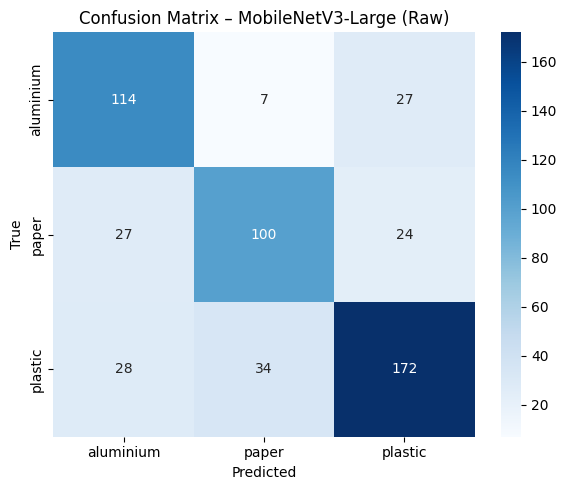

✓ Results logged: MobileNetV3-Large - Raw
  Accuracy: 0.7242, Precision: 0.7273, Recall: 0.7205, F1: 0.7238
✅ Evaluation completed and results logged to final_results.csv


In [8]:
# ============================
# EVALUATION ON SELF-COLLECTED DATA
# ============================


print("\n📊 Evaluating on SELF-COLLECTED dataset...")


test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall: {test_rec*100:.2f}%")
print(f"Test F1-score: {test_f1*100:.2f}%")


# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


# Classification report
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_gen.class_indices.keys(),
yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix – MobileNetV3-Large (Raw)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Log results to CSV
log_result(
    model_name='MobileNetV3-Large',
    experiment_type='Raw',
    accuracy=test_acc,
    precision=test_prec,
    recall=test_rec,
    f1=test_f1,
    loss=test_loss
)

print("✅ Evaluation completed and results logged to final_results.csv")

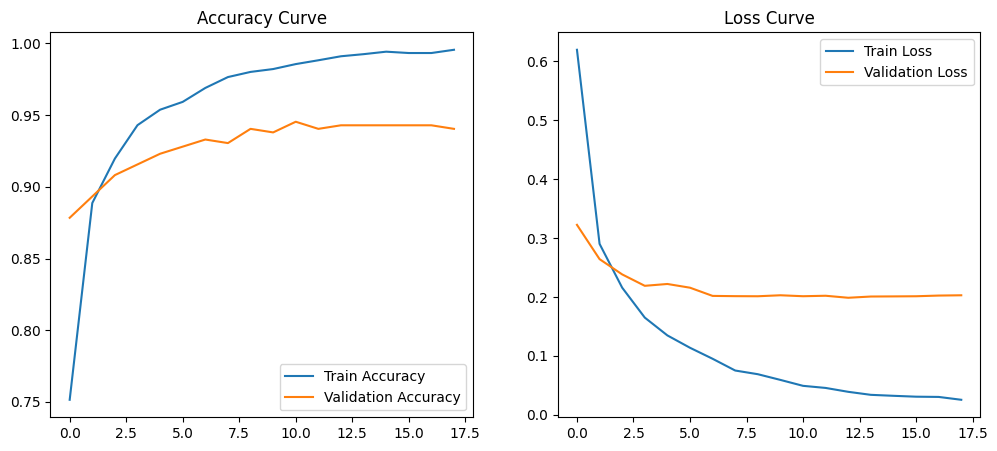

In [9]:
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()

# ============================
# LOAD SAVED MODEL (OPTIONAL)
# ============================
If you have already trained the model, load it instead of training again

In [10]:
# Load saved model if it exists
def load_saved_model(model_path):
    """
    Load a saved Keras model
    
    Args:
        model_path: Path to the saved model file
    
    Returns:
        Loaded Keras model or None
    """
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        from tensorflow import keras
        model = keras.models.load_model(model_path)
        print("✓ Model loaded successfully")
        return model
    else:
        print(f"❌ Model not found at {model_path}")
        return None

# Try to load the saved model
model_path = 'models/mobilenetv3large_raw.keras'
loaded_model = load_saved_model(model_path)

if loaded_model is not None:
    print("\n📊 Evaluating loaded model on test set...")
    
    # Recreate test generator
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_directory(
        SELF_RAW_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Evaluate
    test_loss, test_acc, test_prec, test_rec = loaded_model.evaluate(test_gen, verbose=1)
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    
    print(f"\nLoaded Model Results:")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Precision: {test_prec*100:.2f}%")
    print(f"Test Recall: {test_rec*100:.2f}%")
    print(f"Test F1-score: {test_f1*100:.2f}%")
    
    # Log results
    log_result(
        model_name='MobileNetV3-Large',
        experiment_type='Raw',
        accuracy=test_acc,
        precision=test_prec,
        recall=test_rec,
        f1=test_f1,
        loss=test_loss
    )
    
    print("✓ Results logged to final_results.csv")
else:
    print("⚠️ No saved model found. Please train the model first.")

Loading model from models/mobilenetv3large_raw.keras
✓ Model loaded successfully

📊 Evaluating loaded model on test set...
Found 533 images belonging to 3 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.7111 - loss: 1.0069 - precision: 0.7159 - recall: 0.7092

Loaded Model Results:
Test Accuracy: 71.11%
Test Precision: 71.59%
Test Recall: 70.92%
Test F1-score: 71.25%
✓ Results logged: MobileNetV3-Large - Raw
  Accuracy: 0.7111, Precision: 0.7159, Recall: 0.7092, F1: 0.7125
✓ Results logged to final_results.csv
